<a href="https://colab.research.google.com/github/ryoungj/ObsScaling/blob/main/base_llm_post_training.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Post-Training Scaling Analysis

This notebook shows how to apply observational scaling laws to analyze the scaling of post-training techniques like Chain-of-Thought and Self-Consistency, corresponding to the Sec 4.3 of the paper.

## Preparation

Colab specific setup: uncomment the following lines in colab

In [2]:
# ! git clone https://github.com/ryoungj/ObsScaling
# %cd ObsScaling
# ! pip install -r requirements.txt

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import re
import copy

from utils import *

In [4]:
%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Load Eval Data

Load benchmark eval results for base LLMs

In [5]:
base_llm_benchmark_eval = load_base_llm_benchmark_eval()

In [6]:
base_llm_benchmark_eval

Model    Model Family  Model Size (B)  \
0               meta-llama/Llama-2-7b-hf         Llama-2             7.0   
1              meta-llama/Llama-2-13b-hf         Llama-2            13.0   
2              meta-llama/Llama-2-70b-hf         Llama-2            70.0   
3                    huggyllama/llama-7b           Llama             6.7   
4                   huggyllama/llama-13b           Llama            13.0   
..                                   ...             ...             ...   
72                 bigcode/starcoder2-7b      StarCoder2             7.0   
73                 bigcode/starcoder2-3b      StarCoder2             3.0   
74  deepseek-ai/deepseek-coder-1.3b-base  DeepSeek-Coder             1.3   
75  deepseek-ai/deepseek-coder-6.7b-base  DeepSeek-Coder             6.7   
76   deepseek-ai/deepseek-coder-33b-base  DeepSeek-Coder            33.0   

    Pretraining Data Size (T)  FLOPs (1E21)      MMLU     ARC-C  HellaSwag  \
0                         2.0          84.0  0.437961  0.530717   0.777435   
1                         2.0         156.0  0.543378  0.581058   0.809699   
2                         2.0         840.0  0.698321  0.673208   0.873332   
3                         1.0          40.2  0.356933  0.509386   0.778132   
4                         1.0          78.0  0.476106  0.561433   0.809201   
..                        ...           ...       ...       ...        ...   
72                        3.7         155.4  0.412133  0.383106   0.519120   
73                        3.3          59.4  0.386486  0.345563   0.476200   
74                        2.0          15.6  0.260247  0.257679   0.392750   
75                        2.0          80.4  0.383914  0.370307   0.534555   
76                        2.0         396.0  0.409137  0.424915   0.599881   

    Winograd  TruthfulQA     GSM8K  XWinograd  HumanEval  
0   0.740331    0.389802  0.144807   0.754881   0.128049  
1   0.766377    0.341724  0.228203   0.786798   0.182927  
2   0.837411    0.449235  0.540561   0.824453   0.298780  
3   0.714286    0.343279  0.080364   0.693204   0.128049  
4   0.762431    0.394789  0.075815   0.730362   0.158537  
..       ...         ...       ...        ...        ...  
72  0.591949    0.419935  0.250948   0.620090   0.354000  
73  0.545383    0.404870  0.196361   0.603683   0.317000  
74  0.527230    0.426137  0.029568   0.606346   0.287000  
75  0.580900    0.402813  0.179682   0.678871   0.476000  
76  0.624309    0.399702  0.300227   0.696132   0.512000  

[77 rows x 13 columns]

Load post-training eval results for base LLMs

In [7]:
eval_result_path = "./eval_results/base_llm_post_training_eval.csv"

post_training_eval = pd.read_csv(eval_result_path)

Merge eval results

In [8]:
base_llm_eval_with_post_training = pd.merge(base_llm_benchmark_eval, post_training_eval, on="Model")

## Scaling Analysis

Setup arguments

In [9]:
SCALING_SETUP_KWARGS = {
    # Data preprocessing: PCA imputation and extraction
    **NONGSM_PCA_PREPROCESS_KWARGS,  # exclude GSM to avoid making the task trivial, e.g., using GSM to predict GSM
    
    # Non-lineariy: sigmoid with parametrized scale and shift
    "nonlinearity": "sigmoid-parametric", 

    # Cutoff: 8.4E22 FLOPs corresponding to LLama-2 7B
    "split_method": "cutoff_by_FLOPs (1E21)",
    "cutoff_threshold": 84,

    # Model families: include all we have evaled
    "df_filter": lambda x: x['Model Family'].isin(EVAL_BASE_MODEL_FAMILIES),   
    "df_groupby": 'Model Family',  # group markers by model family

    # Regression: ordinary least squares
    "reg_method": "robust",  
    "reg_kwargs": {"delta": 1.0},  # huber loss with delta=1.0 for normalized target within [0, 1] reduces to OLS
}

In [10]:
PLOT_X_METRICS_LIST = [MODEL_SIZE_METRIC, TRAINING_FLOPS_METRIC, PC_METRIC_NUM_3]   # plot scaling comparison w.r.t. model size, training FLOPs, and 3 PCs

### GSM8K

#### Setup

Specify downstream metrics for analysis

In [11]:
## GSM8K eval metrics with CoT and self-consistency
GSM8K_METHOD_SCALING_COT_METRIC_MAP = {
    'gsm8k_5_exact_match,flexible-extract': "Naive + Greedy",
    'gsm8k_cot_8_exact_match,flexible-extract': "CoT + Greedy",
}

GSM8K_METHOD_SCALING_SELFCONS_METRIC_MAP = {
    'gsm8k_cot_self_consistency_8_exact_match,score-first-flexible-extract': "CoT + 1 Sample",
    'gsm8k_cot_self_consistency_8_exact_match,maj@5-flexible-extract': "CoT + SC + 5 Samples",
}

GSM8K_METHOD_SCALING_ORIG_METRIC_MAP = {
    **GSM8K_METHOD_SCALING_COT_METRIC_MAP,
    **GSM8K_METHOD_SCALING_SELFCONS_METRIC_MAP,
}

GSM8K_COT_SCALING_METRICS = list(GSM8K_METHOD_SCALING_COT_METRIC_MAP.keys())
GSM8K_SELFCONS_SCALING_METRICS = list(GSM8K_METHOD_SCALING_SELFCONS_METRIC_MAP.keys())

GSM8K_METHOD_SCALING_METRICS = [
    'gsm8k_5_exact_match,flexible-extract',
    'gsm8k_cot_8_exact_match,flexible-extract',
    # 'gsm8k_cot_self_consistency_8_exact_match,score-first-flexible-extract',
    'gsm8k_cot_self_consistency_8_exact_match,maj@5-flexible-extract',
]

Plot styling

In [12]:
color_palette = sns.color_palette()

GSM8K_METHOD_SCALING_COLOR_MAP = {
    'gsm8k_5_exact_match,flexible-extract': color_palette[1],
    'gsm8k_cot_8_exact_match,flexible-extract': color_palette[0],
    'gsm8k_cot_self_consistency_8_exact_match,score-first-flexible-extract': color_palette[0],
    'gsm8k_cot_self_consistency_8_exact_match,maj@5-flexible-extract': color_palette[2],
}


GSM8K_SETUP_SPECIFIC_KWARGS = {}
for e in GSM8K_METHOD_SCALING_METRICS:
    GSM8K_SETUP_SPECIFIC_KWARGS[e] = {
        "plot_adjust_kwargs": {"title": GSM8K_METHOD_SCALING_ORIG_METRIC_MAP[e], "ylabel": "Accuracy"},
    }

    if e != "gsm8k_5_exact_match,flexible-extract":
        GSM8K_SETUP_SPECIFIC_KWARGS[e]["plot_adjust_kwargs"].update({"ylim": [-0.03, 0.97]})
    if e in ["gsm8k_5_exact_match,flexible-extract"]:
        GSM8K_SETUP_SPECIFIC_KWARGS[e]["grace_range_ratios"] = [0.05, 0.12]


#### Scaling Predictions

Compare the scaling predictions with observation scaling laws (PCs) and with compute scaling laws (model size or training FLOPs)

split_method cutoff_by_FLOPs (1E21)
heldout filter None
nonlinearity sigmoid-parametric
sigmoid_param_range_width 0.2
sigmoid_param_fix_height True
reg_method robust
reg_kwargs {'delta': 1.0}
reg method robust
fit robust
minimize
fit results {'fit_func': <function fit_multivariate_regression_model.<locals>.<lambda> at 0x7f69b8731b20>, 'linear_func': <function fit_multivariate_regression_model.<locals>.<lambda> at 0x7f69b87319e0>, 'nonlinear_func': <function fit_multivariate_regression_model.<locals>.<lambda> at 0x7f69b8731a80>, 'fit_func_form': 'y = 0.99sigmoid(0.18Log$_{10}$(Model Size (B)) - 3.64) + 0.01', 'linear_func_form': '0.18Log$_{10}$(Model Size (B)) - 3.64', 'nonlinear_func_form': 'y = 0.99sigmoid(x) + 0.01', 'popt': array([-3.63521833,  0.1823965 ]), 'inverse_nonlinearity_func': <function fit_multivariate_regression_model.<locals>.<lambda> at 0x7f69b8731bc0>, 'nonlinear_params': (0.9942578666002336, 0.005742133399766386)}
split_method cutoff_by_FLOPs (1E21)
heldout filter No

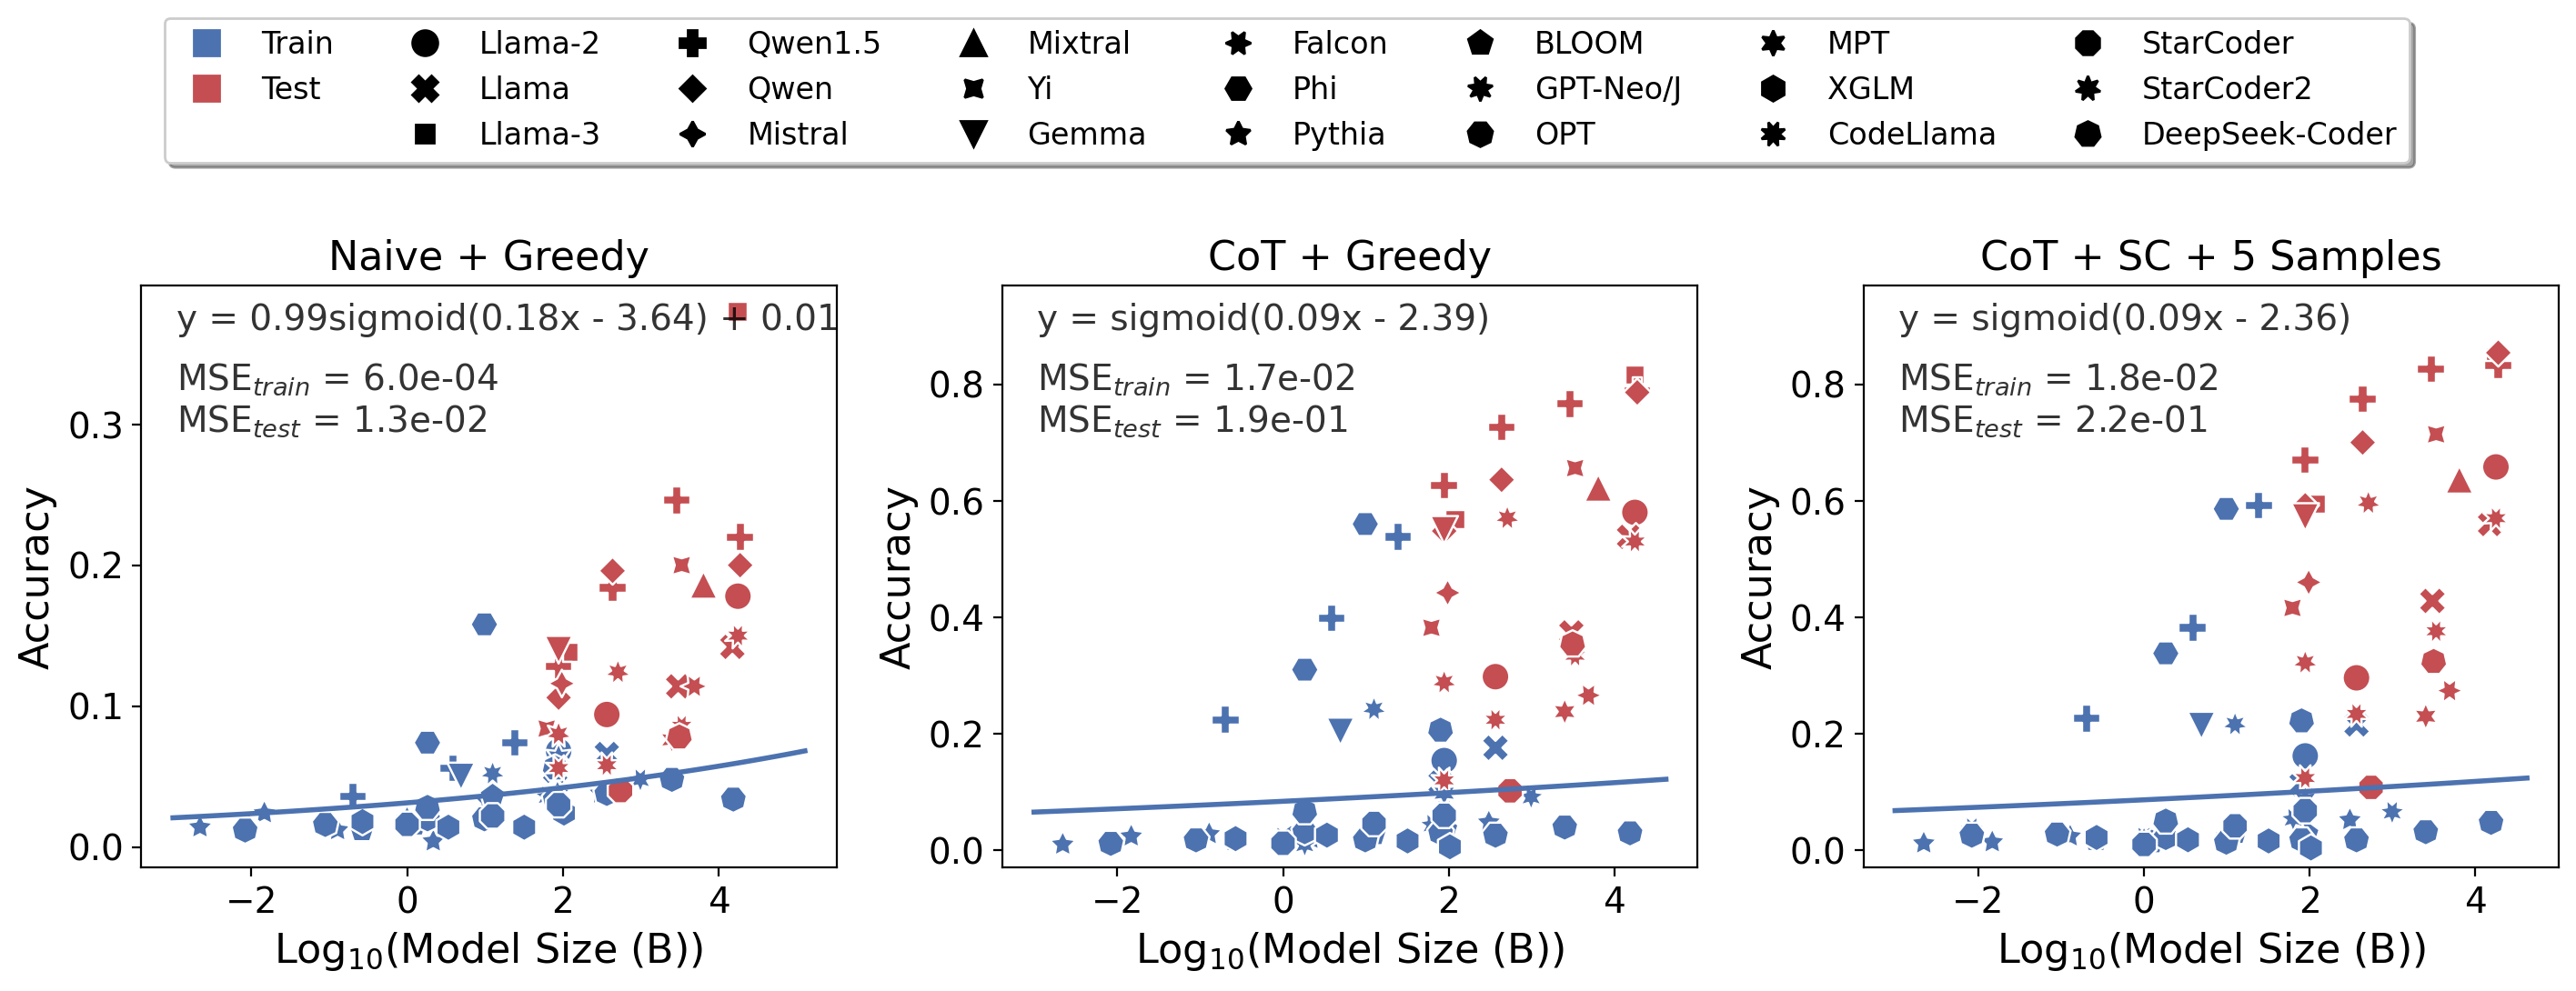

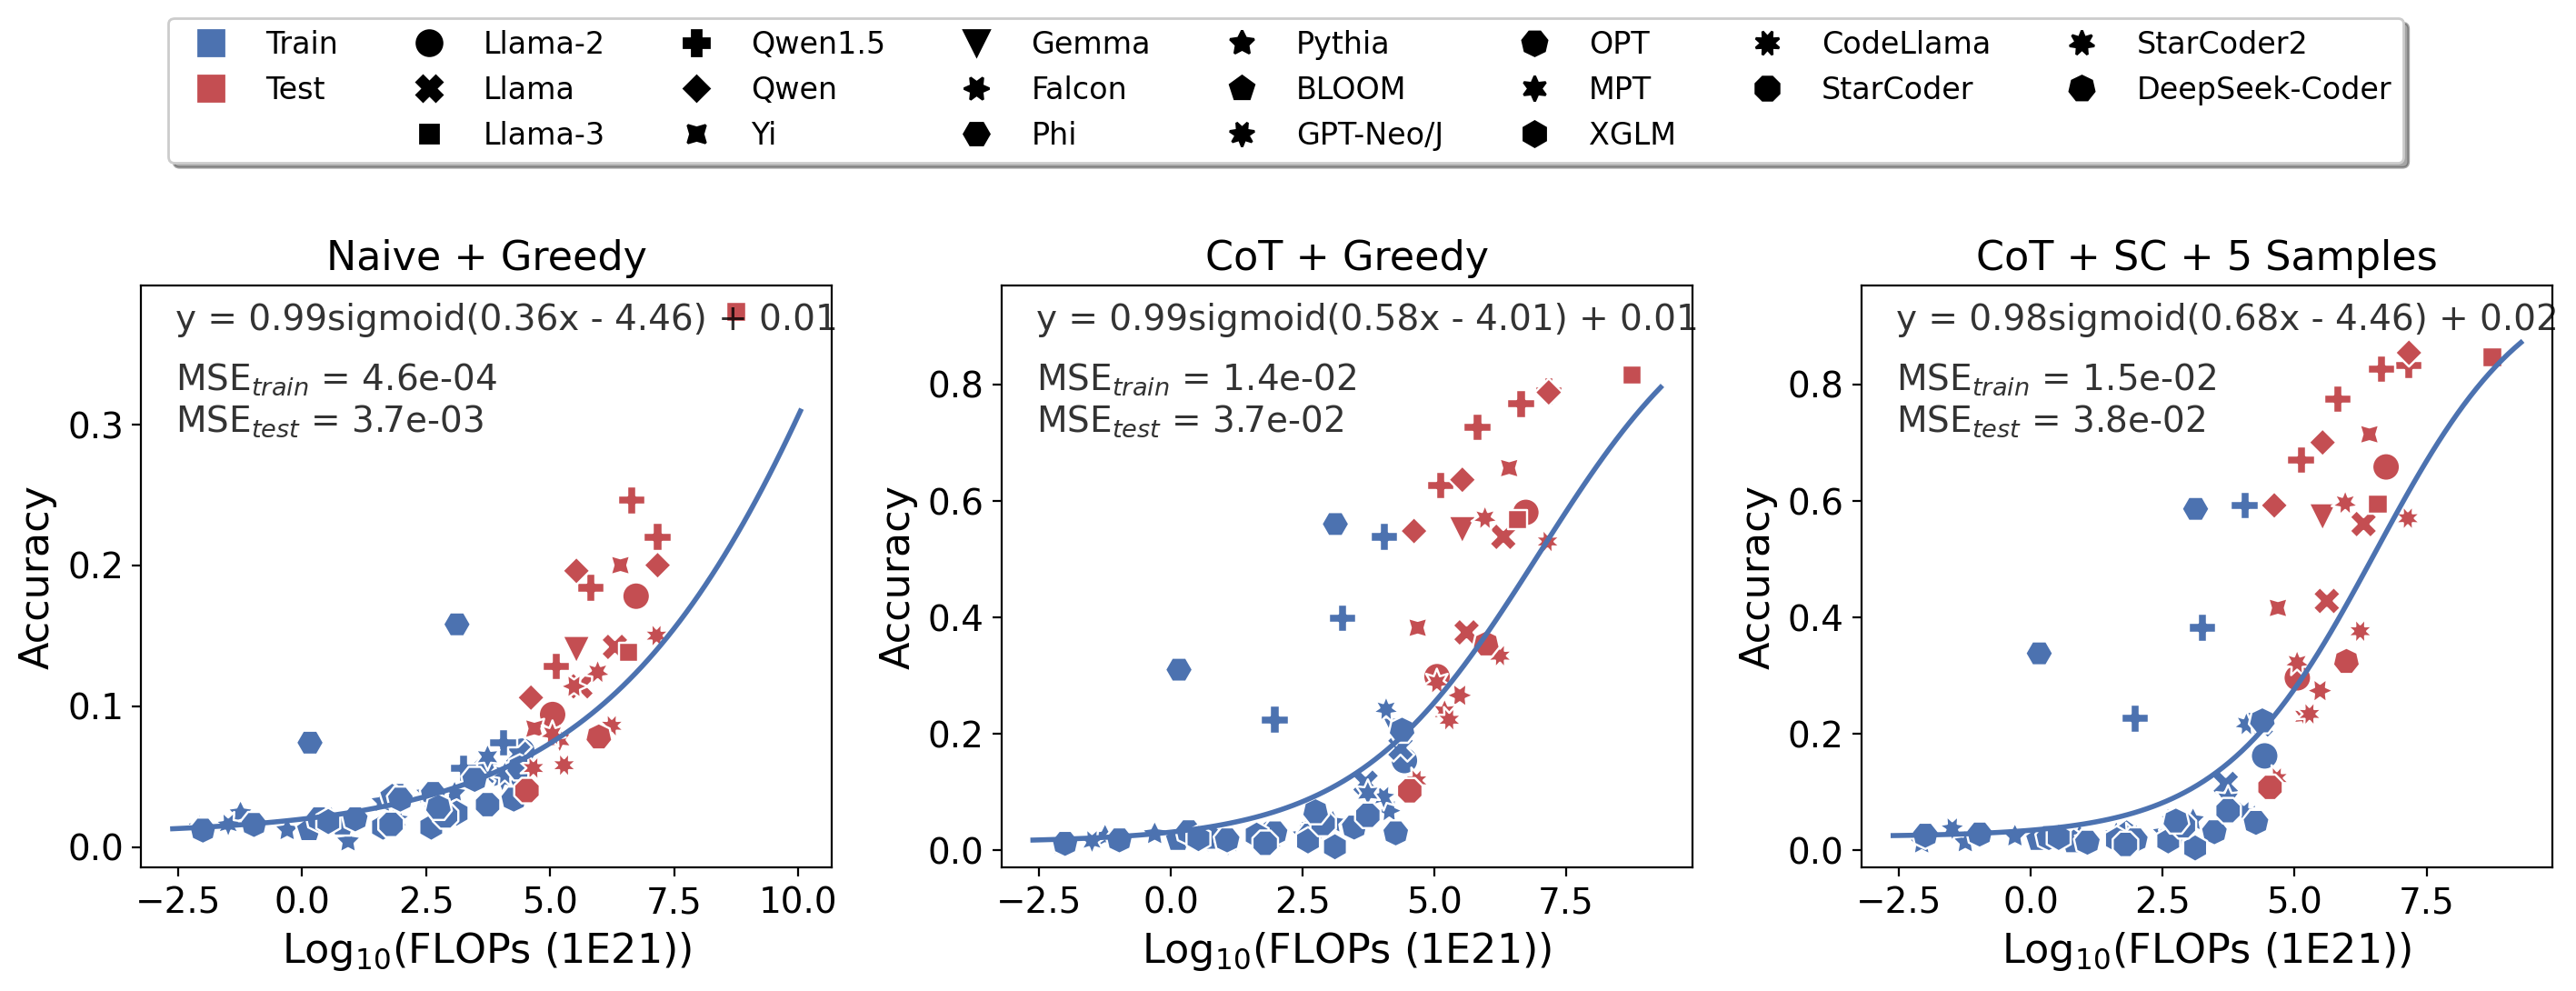

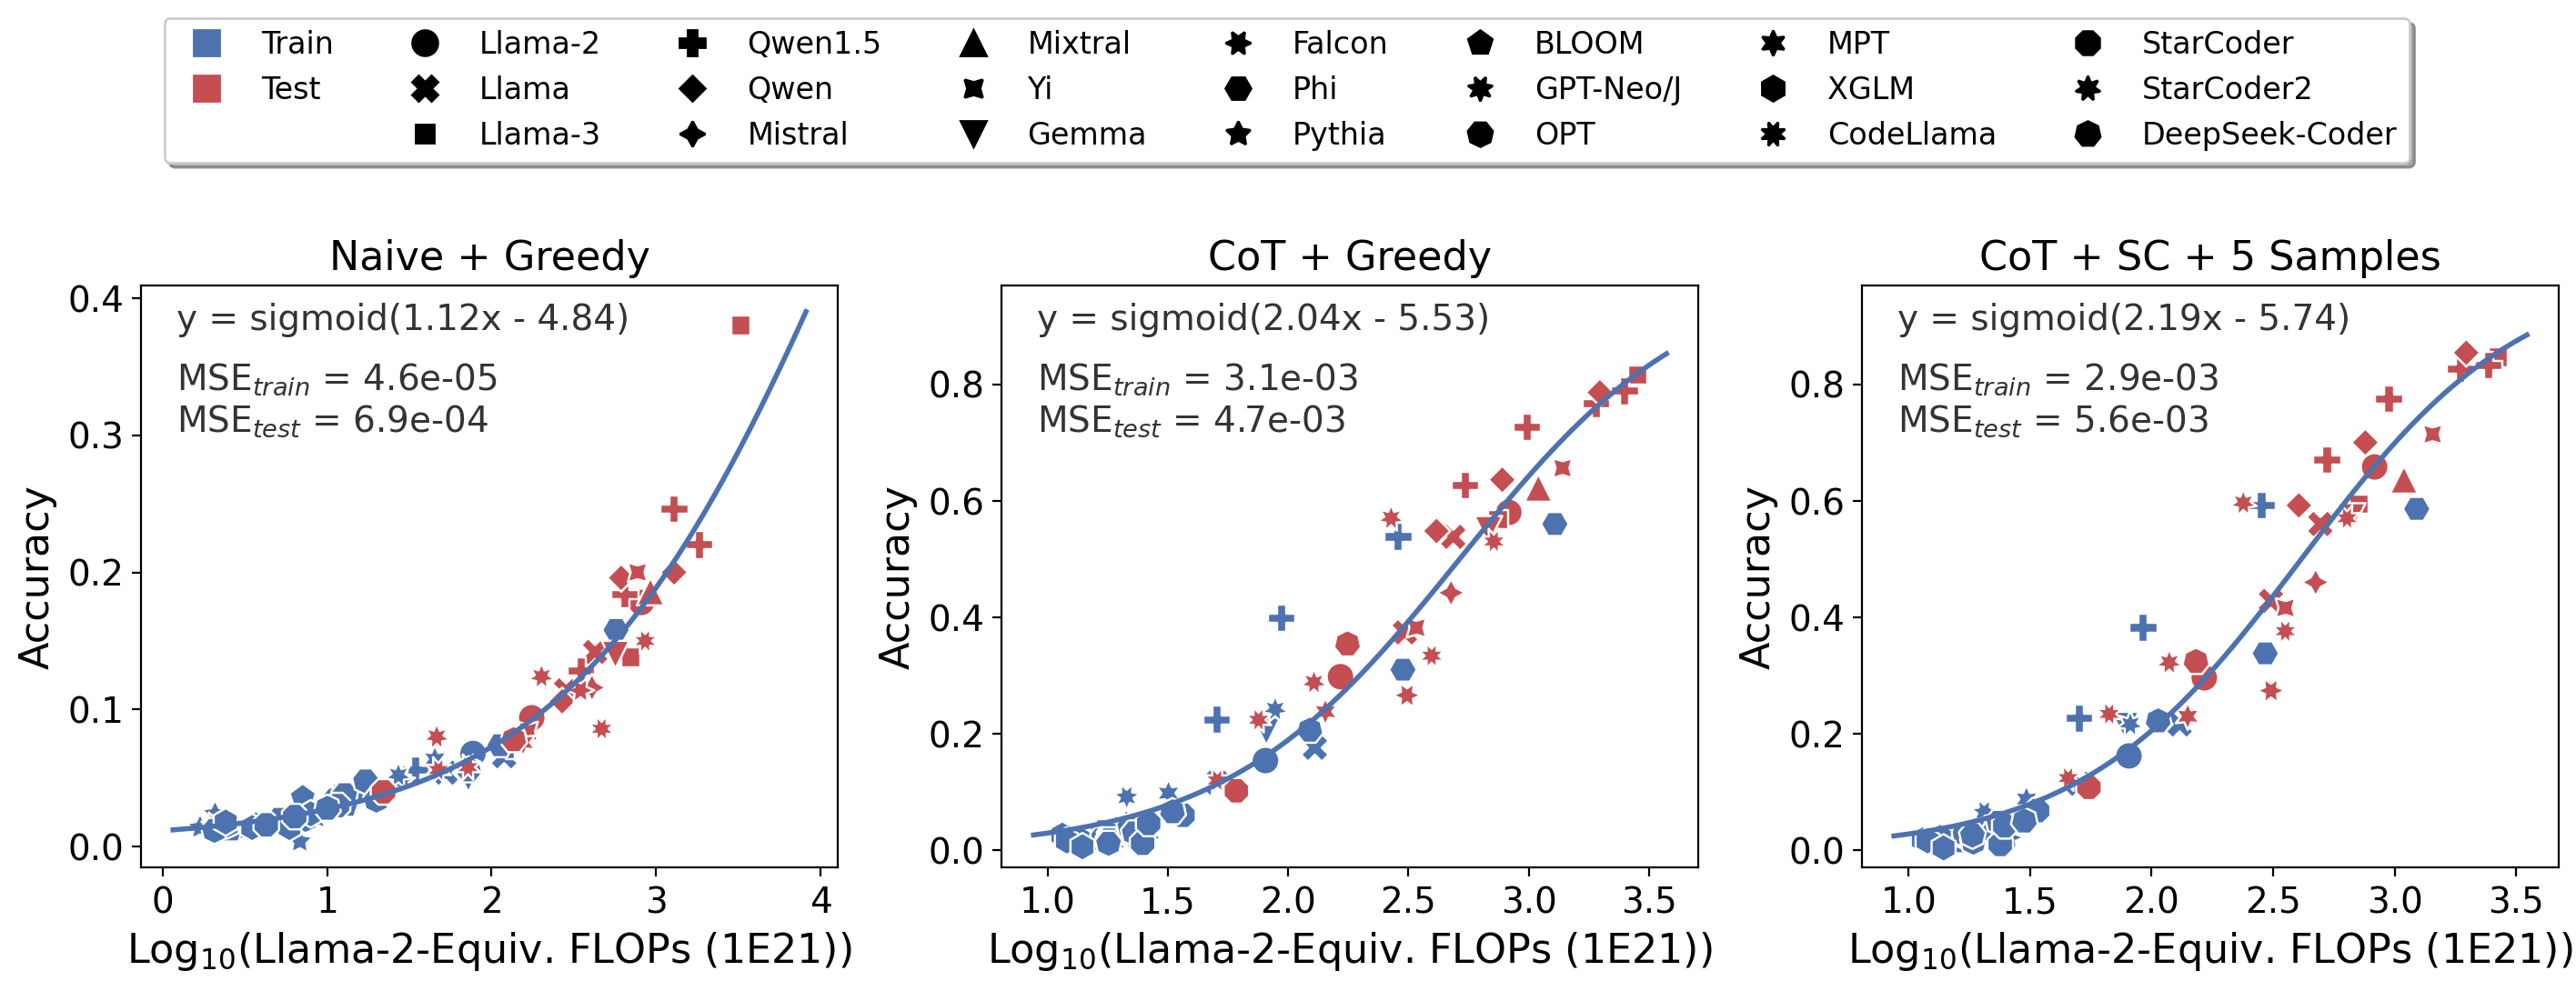

In [13]:
for x_metrics in PLOT_X_METRICS_LIST:
    fig = plot_multi_scaling_predictions(
        base_llm_eval_with_post_training, GSM8K_METHOD_SCALING_METRICS, [x_metrics], 
        SCALING_SETUP_KWARGS, y_metric_specific_kwargs=GSM8K_SETUP_SPECIFIC_KWARGS,
        plot_legend=True, legend_nrow=3, legend_font_size=12, add_dummy_labels=1
    )

Compare the scaling of base LLM performance with and without post-training methods

y_metric_list ['gsm8k_5_exact_match,flexible-extract', 'gsm8k_cot_8_exact_match,flexible-extract']
analysis_setup_kwargs {'apply_imputation': True, 'imputation_metrics': ['MMLU', 'ARC-C', 'HellaSwag', 'Winograd', 'TruthfulQA', 'XWinograd', 'HumanEval'], 'imputation_kwargs': {'n_components': 1, 'verbose': False, 'boundary': [0.0, 1.0]}, 'apply_pca': True, 'pca_metrics': ['MMLU', 'ARC-C', 'HellaSwag', 'Winograd', 'TruthfulQA', 'XWinograd', 'HumanEval'], 'pca_kwargs': {'n_components': 5, 'standardize': False}, 'nonlinearity': 'sigmoid-parametric', 'split_method': 'cutoff_by_FLOPs (1E21)', 'cutoff_threshold': 84, 'df_filter': <function <lambda> at 0x7f69b89c3880>, 'df_groupby': 'Model Family', 'reg_method': 'robust', 'reg_kwargs': {'delta': 1.0}}
y_metric_specific_kwargs {'gsm8k_5_exact_match,flexible-extract': {'plot_adjust_kwargs': {'title': 'Naive + Greedy', 'ylabel': 'Accuracy'}, 'grace_range_ratios': [0.05, 0.12]}, 'gsm8k_cot_8_exact_match,flexible-extract': {'plot_adjust_kwargs': {'t

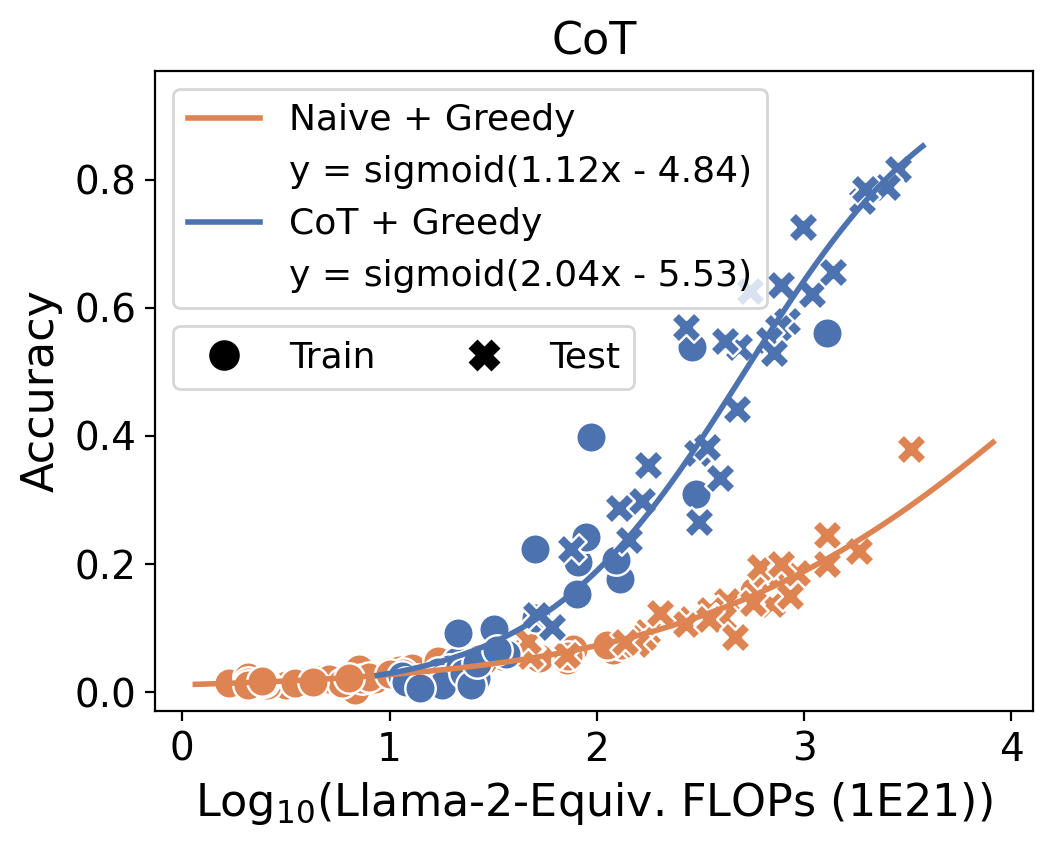

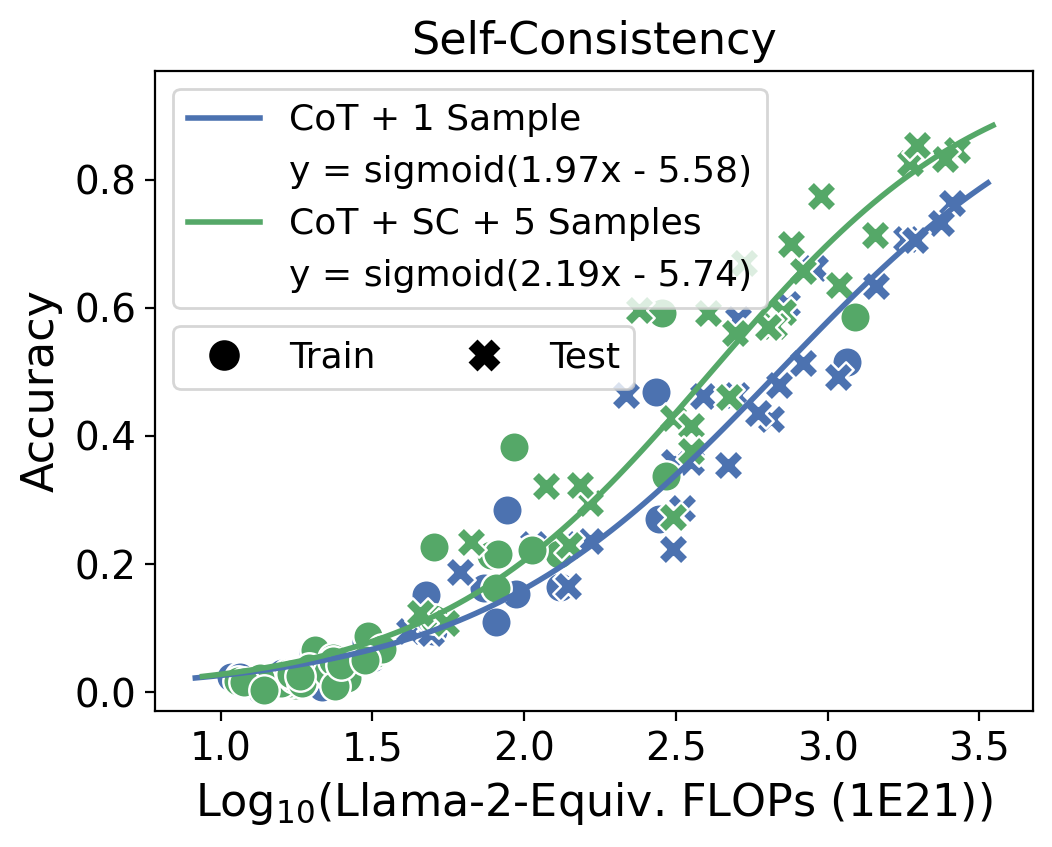

In [14]:
fig = plot_scaling_comparison_multi_metrics(
    base_llm_eval_with_post_training, GSM8K_COT_SCALING_METRICS, [PC_METRIC_NUM_3], 
    SCALING_SETUP_KWARGS, y_metric_specific_kwargs=GSM8K_SETUP_SPECIFIC_KWARGS,
    ymetric2title_map=GSM8K_METHOD_SCALING_ORIG_METRIC_MAP, ymetric2color_map=GSM8K_METHOD_SCALING_COLOR_MAP,
    plot_title="CoT"
)

fig = plot_scaling_comparison_multi_metrics(
    base_llm_eval_with_post_training, GSM8K_SELFCONS_SCALING_METRICS, [PC_METRIC_NUM_3], 
    SCALING_SETUP_KWARGS, y_metric_specific_kwargs=GSM8K_SETUP_SPECIFIC_KWARGS, 
    ymetric2title_map=GSM8K_METHOD_SCALING_ORIG_METRIC_MAP, ymetric2color_map=GSM8K_METHOD_SCALING_COLOR_MAP,
    plot_title="Self-Consistency",
)

split_method cutoff_by_FLOPs (1E21)
heldout filter None
nonlinearity sigmoid-parametric
sigmoid_param_range_width 0.2
sigmoid_param_fix_height True
reg_method robust
reg_kwargs {'delta': 1.0}
reg method robust
fit robust
minimize
fit results {'fit_func': <function fit_multivariate_regression_model.<locals>.<lambda> at 0x7f69af882b60>, 'linear_func': <function fit_multivariate_regression_model.<locals>.<lambda> at 0x7f69af882d40>, 'nonlinear_func': <function fit_multivariate_regression_model.<locals>.<lambda> at 0x7f69af883c40>, 'fit_func_form': 'y = sigmoid(2.82PC-1 + 1.59PC-2 - 0.18PC-3 - 3.62)', 'linear_func_form': '2.82PC-1 + 1.59PC-2 - 0.18PC-3 - 3.62', 'nonlinear_func_form': 'y = sigmoid(x)', 'popt': array([-3.62381712,  2.82389294,  1.59096627, -0.17974442]), 'inverse_nonlinearity_func': <function fit_multivariate_regression_model.<locals>.<lambda> at 0x7f69af883e20>, 'nonlinear_params': (0.9960631074994034, 0.003936892500596571)}
pca_weights [ 2.82389294  1.59096627 -0.17974442]

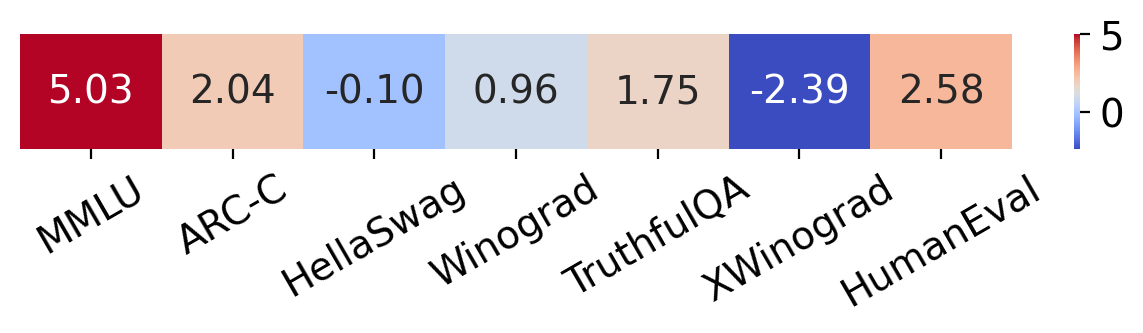

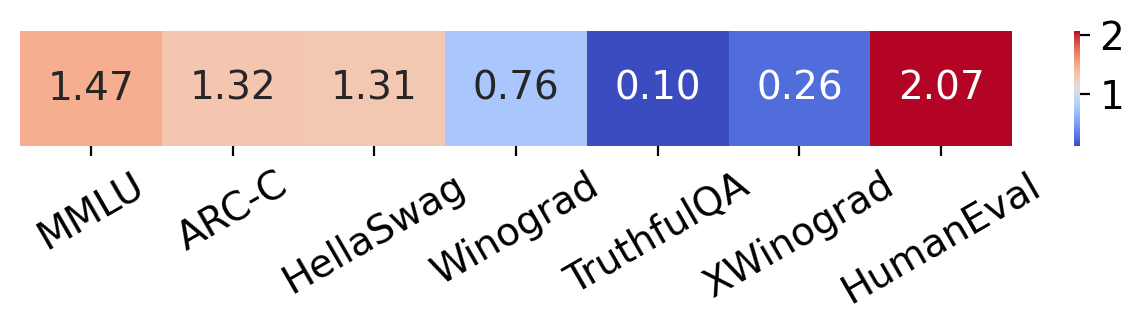

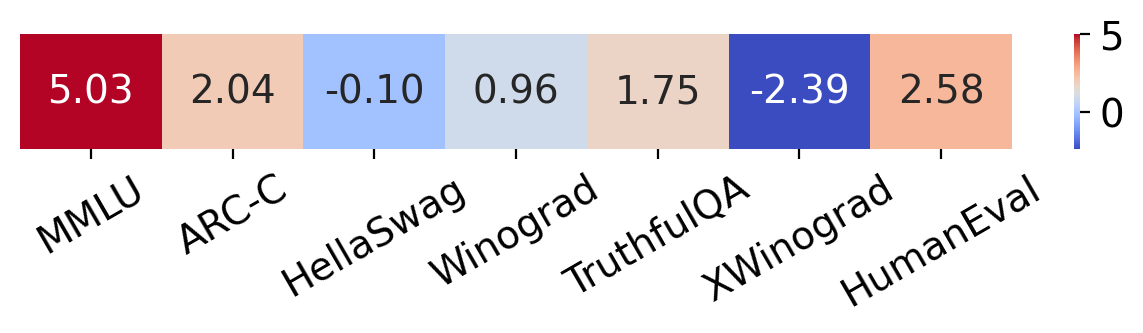

In [15]:
plot_weight_analysis(
    base_llm_eval_with_post_training, GSM8K_COT_SCALING_METRICS, [PC_METRIC_NUM_3], 
    SCALING_SETUP_KWARGS
)

Comparing the scaling across different model families

split_method cutoff_by_FLOPs (1E21)
heldout filter None
nonlinearity sigmoid-parametric
sigmoid_param_range_width 0.2
sigmoid_param_fix_height True
reg_method robust
reg_kwargs {'delta': 1.0}
reg method robust
fit robust
minimize
fit results {'fit_func': <function fit_multivariate_regression_model.<locals>.<lambda> at 0x7f69af5daac0>, 'linear_func': <function fit_multivariate_regression_model.<locals>.<lambda> at 0x7f69af5da980>, 'nonlinear_func': <function fit_multivariate_regression_model.<locals>.<lambda> at 0x7f69af5daa20>, 'fit_func_form': 'y = sigmoid(2.56PC-1 + 4.64PC-2 - 4.21PC-3 - 2.50)', 'linear_func_form': '2.56PC-1 + 4.64PC-2 - 4.21PC-3 - 2.50', 'nonlinear_func_form': 'y = sigmoid(x)', 'popt': array([-2.49829015,  2.56492253,  4.64263211, -4.20720616]), 'inverse_nonlinearity_func': <function fit_multivariate_regression_model.<locals>.<lambda> at 0x7f69af5dab60>, 'nonlinear_params': (1.0, 0.0)}
split_method cutoff_by_FLOPs (1E21)
heldout filter None
nonlinearity sigmoid-para

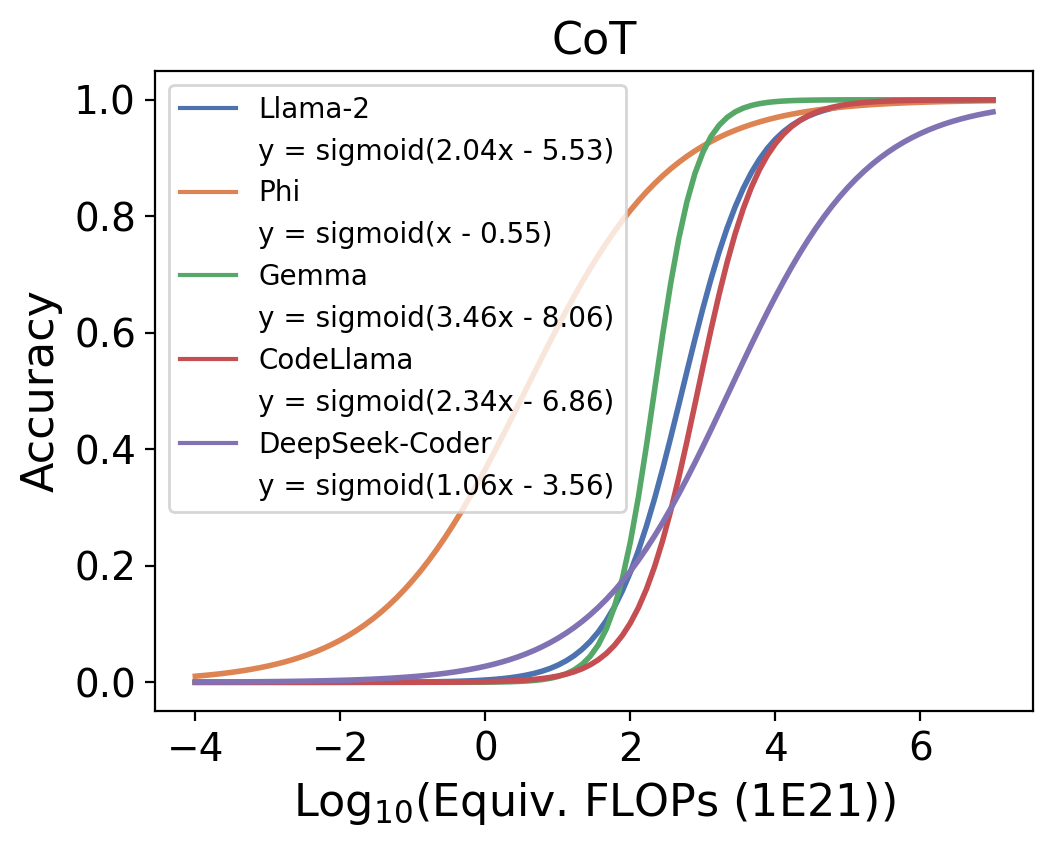

In [16]:
GSM8K_REF_FAMILY_COMPARE = ["Llama-2", "Phi", "Gemma", "CodeLlama", "DeepSeek-Coder"]
GSM8K_REF_FAMILY_COMPARE_SETUP_KWARGS = SCALING_SETUP_KWARGS.copy()
GSM8K_REF_FAMILY_COMPARE_SETUP_KWARGS["plot_adjust_kwargs"] = {"title": "CoT", "ylabel": "Accuracy", "xlabel": "Log$_{{10}}$(Equiv. FLOPs (1E21))"}

fig = plot_scaling_comparison_multi_families(
    base_llm_eval_with_post_training, GSM8K_COT_SCALING_METRICS[1], [PC_METRIC_NUM_3], GSM8K_REF_FAMILY_COMPARE, 
    GSM8K_REF_FAMILY_COMPARE_SETUP_KWARGS, title_off=True, plot_xrange=[-4, 7]
)

#### Robustness Analysis

The effect of PCs: compare the scaling predictions using different number of PCs and with training FLOPs as baseline

split_method cutoff_by_FLOPs (1E21)
heldout filter None
nonlinearity sigmoid-parametric
sigmoid_param_range_width 0.2
sigmoid_param_fix_height True
reg_method robust
reg_kwargs {'delta': 1.0}
reg method robust
fit robust
minimize
fit results {'fit_func': <function fit_multivariate_regression_model.<locals>.<lambda> at 0x7f69af63dee0>, 'linear_func': <function fit_multivariate_regression_model.<locals>.<lambda> at 0x7f69af651760>, 'nonlinear_func': <function fit_multivariate_regression_model.<locals>.<lambda> at 0x7f69af63de40>, 'fit_func_form': 'y = 0.99sigmoid(0.36Log$_{10}$(FLOPs (1E21)) - 4.46) + 0.01', 'linear_func_form': '0.36Log$_{10}$(FLOPs (1E21)) - 4.46', 'nonlinear_func_form': 'y = 0.99sigmoid(x) + 0.01', 'popt': array([-4.46358801,  0.36162064]), 'inverse_nonlinearity_func': <function fit_multivariate_regression_model.<locals>.<lambda> at 0x7f69af63df80>, 'nonlinear_params': (0.99152864706866, 0.008471352931340102)}
split_method cutoff_by_FLOPs (1E21)
heldout filter None
non

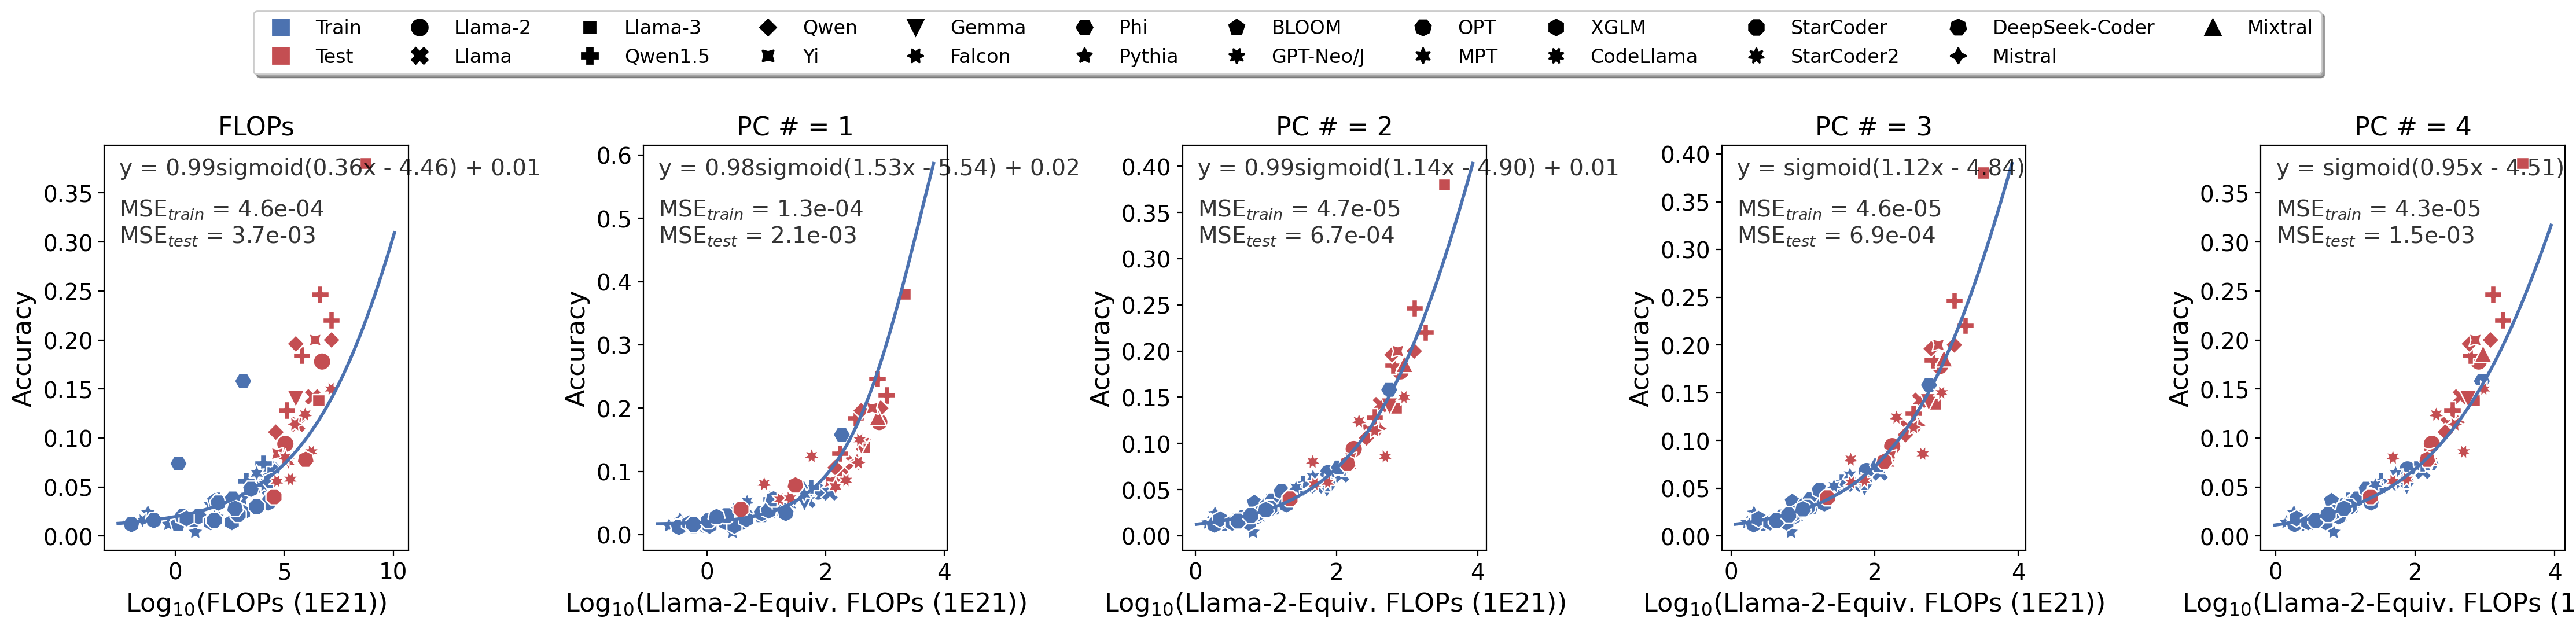

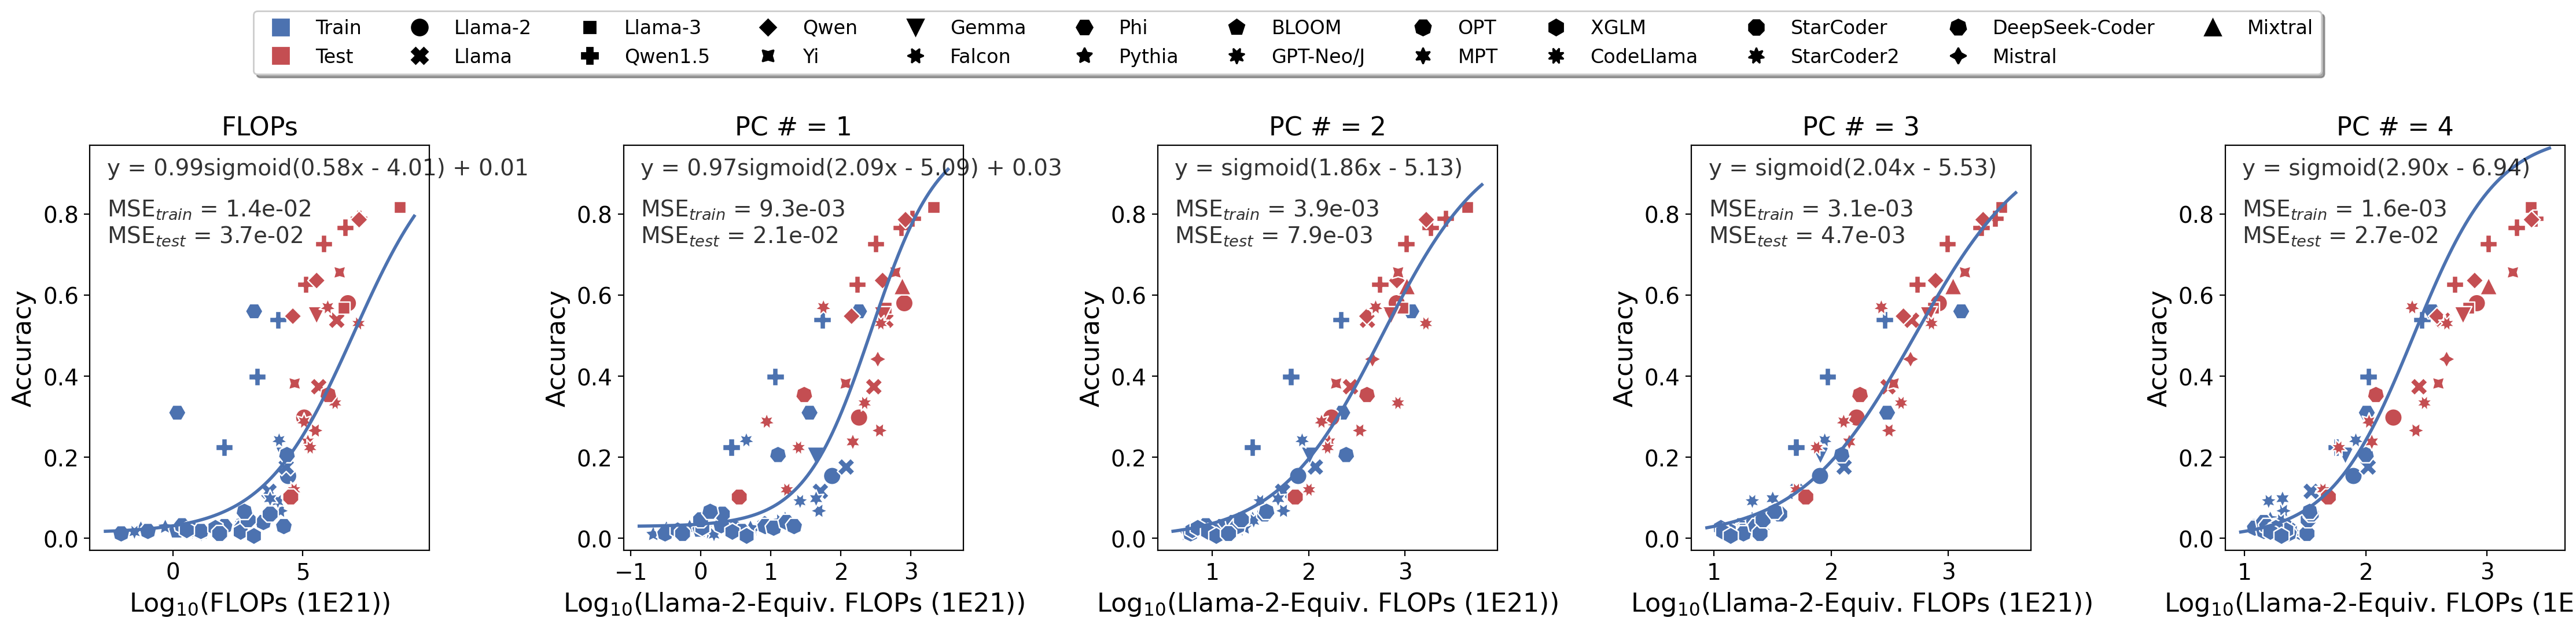

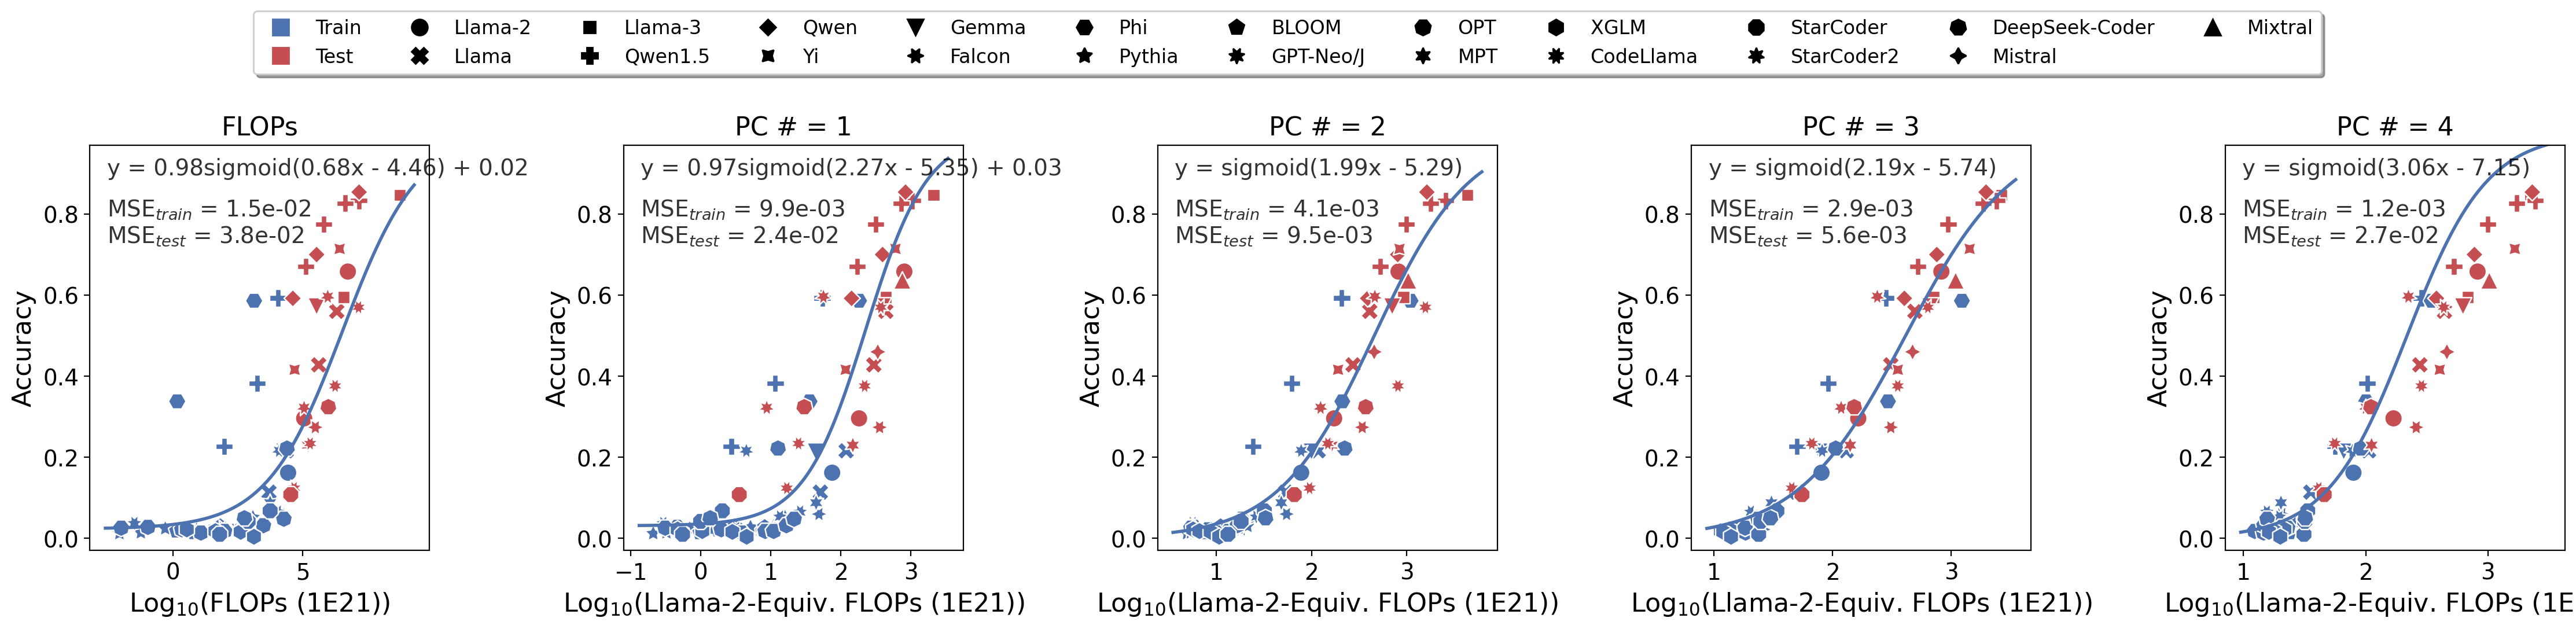

In [17]:
DIFF_PC_NUM_PLOT_X_METRICS_LIST = [TRAINING_FLOPS_METRIC, PC_METRIC_NUM_1, PC_METRIC_NUM_2, PC_METRIC_NUM_3, PC_METRIC_NUM_4]

for y_metric in GSM8K_METHOD_SCALING_METRICS:
    fig = plot_multi_scaling_predictions(
        base_llm_eval_with_post_training, [y_metric], DIFF_PC_NUM_PLOT_X_METRICS_LIST, SCALING_SETUP_KWARGS, 
        y_metric_specific_kwargs=GSM8K_SETUP_SPECIFIC_KWARGS,
        plot_legend=True, 
        legend_nrow=2, legend_font_size=12, add_dummy_labels=0, 
        transpose=True
    )

The effect of cutoff: vary the FLOPs cutoff, plot the test MSE, and compute the mean test MSE (area under the error curve)

0it [00:00, ?it/s]

split_methodsplit_method split_methodsplit_methodsplit_methodrank_by_FLOPs (1E21)  rank_by_FLOPs (1E21) 
rank_by_FLOPs (1E21) 

rank_by_FLOPs (1E21)split_methodrank_by_FLOPs (1E21)heldout filter 
 heldout filterheldout filterrank_by_FLOPs (1E21)
None
 split_method 
NoneNone heldout filtersplit_methodheldout filter

 rank_by_FLOPs (1E21)heldout filtersplit_method 
None rank_by_FLOPs (1E21)split_method  

Noneheldout filterrank_by_FLOPs (1E21)  None
heldout filter
split_methodNonerank_by_FLOPs (1E21) None
heldout filter
  rank_by_FLOPs (1E21)

None

split_methodheldout filterheldout filtersplit_methodsplit_methodsplit_method  split_method None split_methodNone  
 split_methodrank_by_FLOPs (1E21)
 rank_by_FLOPs (1E21)rank_by_FLOPs (1E21) rank_by_FLOPs (1E21)


rank_by_FLOPs (1E21)

split_methodsplit_methodrank_by_FLOPs (1E21)rank_by_FLOPs (1E21)heldout filterheldout filterheldout filter 
 
 rank_by_FLOPs (1E21)heldout filterheldout filterNone 
 split_method
 Nonerank_by_FLOPs (1E21)heldou

1it [00:18, 18.05s/it]

split_methodsplit_methodsplit_methodsplit_methodsplit_methodsplit_method    rank_by_FLOPs (1E21) rank_by_FLOPs (1E21)rank_by_FLOPs (1E21)rank_by_FLOPs (1E21) 
rank_by_FLOPs (1E21)


split_methodheldout filter
heldout filterheldout filter heldout filter   split_method NoneNonerank_by_FLOPs (1E21)rank_by_FLOPs (1E21)heldout filterNoneNone
 split_method

 


 rank_by_FLOPs (1E21)Noneheldout filtersplit_method

heldout filterrank_by_FLOPs (1E21)split_method
    Nonerank_by_FLOPs (1E21)None
rank_by_FLOPs (1E21)heldout filterheldout filter


 heldout filter None Nonesplit_methodheldout filterNone
split_method 
 
split_method Nonerank_by_FLOPs (1E21)
rank_by_FLOPs (1E21) 
split_methodrank_by_FLOPs (1E21)

heldout filter split_method rank_by_FLOPs (1E21)None
 
heldout filterheldout filterrank_by_FLOPs (1E21) split_method 
Nonesplit_methodNonesplit_method 

 rank_by_FLOPs (1E21)heldout filter heldout filterrank_by_FLOPs (1E21)
split_method  split_methodsplit_method
rank_by_FLOPs (1E21)NoneNone 

2it [00:36, 17.99s/it]

split_methodsplit_methodsplit_method   split_methodsplit_methodrank_by_FLOPs (1E21)rank_by_FLOPs (1E21)split_methodrank_by_FLOPs (1E21)  

 
rank_by_FLOPs (1E21)rank_by_FLOPs (1E21)heldout filterrank_by_FLOPs (1E21)

 
heldout filterheldout filterNone 
 heldout filterheldout filterheldout filterNoneNone   
split_method
NoneNoneNonesplit_method
 split_method

 rank_by_FLOPs (1E21)rank_by_FLOPs (1E21)
 split_methodsplit_method
split_methodrank_by_FLOPs (1E21) split_method heldout filter heldout filter
rank_by_FLOPs (1E21)  rank_by_FLOPs (1E21)
NoneNone 
rank_by_FLOPs (1E21)heldout filter
rank_by_FLOPs (1E21)
heldout filter 

 heldout filterNonesplit_method None
heldout filter None
heldout filter
rank_by_FLOPs (1E21) split_methodNone  

Nonerank_by_FLOPs (1E21)

heldout filtersplit_method heldout filterNone  
rank_by_FLOPs (1E21)None

heldout filter None
split_method rank_by_FLOPs (1E21)
heldout filtersplit_methodsplit_method   Nonerank_by_FLOPs (1E21)rank_by_FLOPs (1E21)


split_method h

3it [00:54, 18.11s/it]


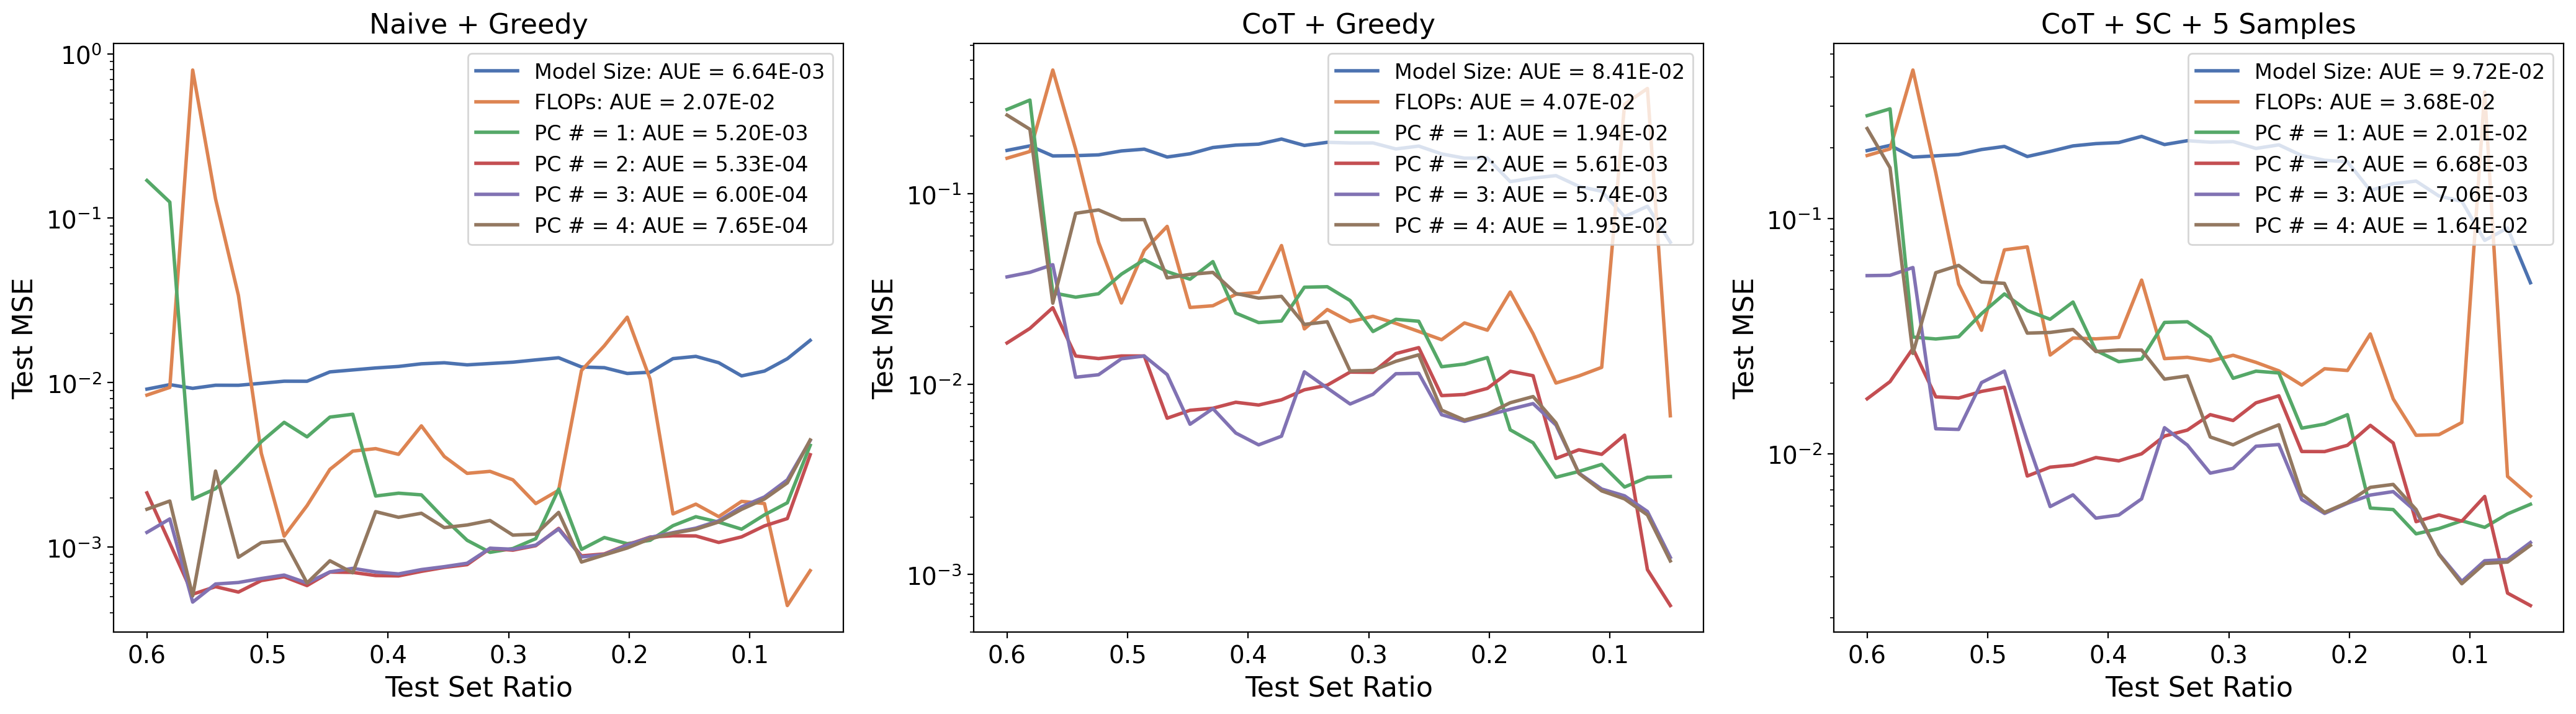

In [18]:
# vary the FLOPs cutoff to change test size from 0.6 to 0.05
rank_metric_name = "FLOPs (1E21)"
split_limit_ranges = np.linspace(0.6, 0.05, 30)

regress_metrics_to_plot = ['mse_test']

setup_kwargs = copy.deepcopy(SCALING_SETUP_KWARGS)
setup_kwargs.pop("df_filter")  # need to be poped as it is not pickable for multiprocessing

fig = plot_reg_metric_curves(
    base_llm_eval_with_post_training,
    ALL_X_METRICS_LIST,
    GSM8K_METHOD_SCALING_METRICS,
    rank_metric_name,
    split_limit_ranges,
    regress_metrics_to_plot,
    setup_kwargs,
    ymetric2title_map=GSM8K_METHOD_SCALING_ORIG_METRIC_MAP,
    filter_model_family=EVAL_BASE_MODEL_FAMILIES,   # added back for filtering
)

### BBH - CoT

#### Setup

Specify downstream metrics for analysis

In [19]:
## Note: BBH task named by "bbh_{fewshot|cot_fewshot}_{subtask|overall}_3_exact_match,flexible-extract[,norm]"
##       where "overall" is the arverage of all subtasks, and ",norm" means normalized by random performance

PLOT_BBH_METHOD_SCALING_ORIG_METRIC_MAP = {
    "bbh_fewshot_overall_3_exact_match,flexible-extract,norm": "Naive - Greedy",
    "bbh_cot_fewshot_overall_3_exact_match,flexible-extract,norm": "CoT - Greedy",
}
PLOT_BBH_METHOD_SCALING_METRICS = list(PLOT_BBH_METHOD_SCALING_ORIG_METRIC_MAP.keys())

color_palette = sns.color_palette()

PLOT_BBH_METHOD_SCALING_COLOR_MAP = {
    'bbh_fewshot_overall_3_exact_match,flexible-extract,norm': color_palette[1],
    'bbh_cot_fewshot_overall_3_exact_match,flexible-extract,norm': color_palette[0],
}


Plot styling

In [20]:
PLOT_BBH_SETUP_SPECIFIC_KWARGS = {}
for e in PLOT_BBH_METHOD_SCALING_METRICS:
    PLOT_BBH_SETUP_SPECIFIC_KWARGS[e] = {
        "plot_adjust_kwargs": {"title": PLOT_BBH_METHOD_SCALING_ORIG_METRIC_MAP[e], "ylabel": "Accuracy"},
    }


#### Scaling Predictions

Compare the scaling of base LLM performance with and without post-training methods

y_metric_list ['bbh_fewshot_overall_3_exact_match,flexible-extract,norm', 'bbh_cot_fewshot_overall_3_exact_match,flexible-extract,norm']
analysis_setup_kwargs {'apply_imputation': True, 'imputation_metrics': ['MMLU', 'ARC-C', 'HellaSwag', 'Winograd', 'TruthfulQA', 'XWinograd', 'HumanEval'], 'imputation_kwargs': {'n_components': 1, 'verbose': False, 'boundary': [0.0, 1.0]}, 'apply_pca': True, 'pca_metrics': ['MMLU', 'ARC-C', 'HellaSwag', 'Winograd', 'TruthfulQA', 'XWinograd', 'HumanEval'], 'pca_kwargs': {'n_components': 5, 'standardize': False}, 'nonlinearity': 'sigmoid-parametric', 'split_method': 'cutoff_by_FLOPs (1E21)', 'cutoff_threshold': 84, 'df_filter': <function <lambda> at 0x7f69b89c3880>, 'df_groupby': 'Model Family', 'reg_method': 'robust', 'reg_kwargs': {'delta': 1.0}}
y_metric_specific_kwargs {'bbh_fewshot_overall_3_exact_match,flexible-extract,norm': {'plot_adjust_kwargs': {'title': 'Naive - Greedy', 'ylabel': 'Accuracy'}}, 'bbh_cot_fewshot_overall_3_exact_match,flexible-e

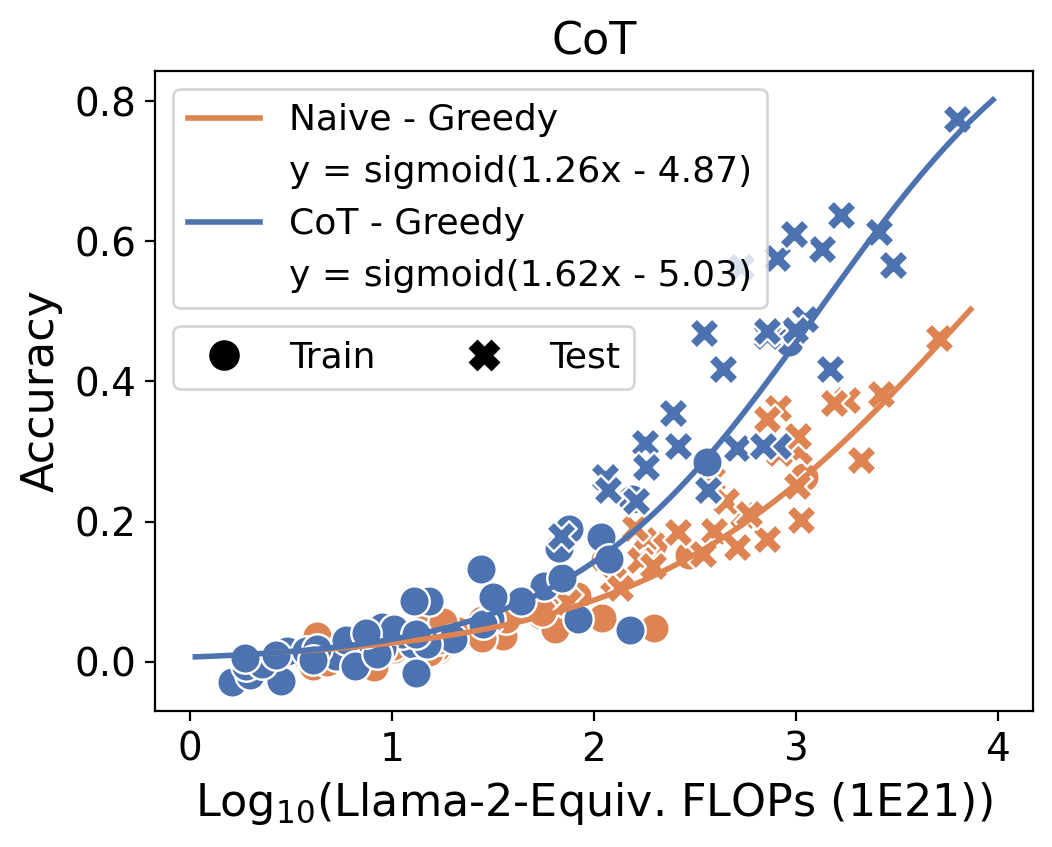

In [21]:
fig = plot_scaling_comparison_multi_metrics(
    base_llm_eval_with_post_training, PLOT_BBH_METHOD_SCALING_METRICS, [PC_METRIC_NUM_3], SCALING_SETUP_KWARGS, 
    y_metric_specific_kwargs=PLOT_BBH_SETUP_SPECIFIC_KWARGS,
    ymetric2title_map=PLOT_BBH_METHOD_SCALING_ORIG_METRIC_MAP, ymetric2color_map=PLOT_BBH_METHOD_SCALING_COLOR_MAP,
    plot_title="CoT"
)